In [1]:
## load some packages
# estimation
from scipy.stats import gaussian_kde
from toolkit.estimation import (
        estimation_G,  # matrix
        log_beta, log_inv_gamma,  # priors
        gen_posterior_prob, get_invhessian,  # number things
        posterior_mode, metropolis_hastings,  # estimation
        historical_decomposition,  # historical decomposition
    )

# model
from models.hankv1 import HANK
from toolkit.irfs import *

# general
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
## intialize model
mod_pars = {
        'gamma': 4., 'chi': 2.,  # household parameters, beta and phi are chosen in calibration
        'N_z': 7, 'rho_z': 0.963, 'sigma_z': 0.134,  # household state transitions
        'kappa': 0.1,  # philips curve
        'rho_B': 0.95, 'omega_pi': 1.5, 'omega_Y': 0.,  # govt parameters
        'A': 1., 'psi': 1.2, 'g': 0.201, 'xi': 1., 'tauP': 1.18, 'eta': 0.081,  # shock steady states
        'pi': 1., 'B': 0.577,  # variable steady states we define (otherwise model can't be solved)
        'I': 1.005, 'Y': 1.,  # varaible steady states we target
        'N_a': 501, 'a_min': 0, 'a_max': 50,  # grid states
    }
hank = HANK(**mod_pars)

## solve steady state
free = ['beta', 'phi']
endog = ['R', 'G', 'tauL', 'N', 'M', 'D', 'curlN', 'curlC', 'curlB']
markets = {m: HANK.markets[m] for m in ['mkt3', 'mkt4']}  # the other markets clear by definition or by an analytic form
V_a0 = (hank.a_grid[:, None] * (hank.I - 1) + hank.z_grid)**(-hank.gamma)
X0 = np.array([0.97, 2.5])
hank.solve_ss(free, endog, V_a0, X0, markets=markets)
assert np.isclose(hank.curlC + hank.G - hank.Y, 0)  # walras

## solve for perturbation matrix
T = 300
G, dxs = hank.solve_G(T, ha=True, h=1e-4)

f'phi = {hank.phi}; beta = {hank.beta}'

'phi = 2.5491621758196934; beta = 0.9654434908711715'

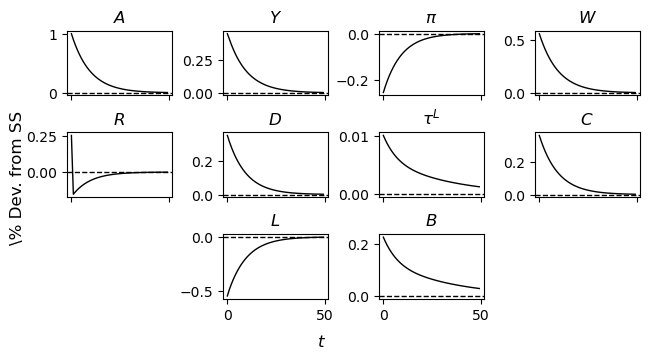

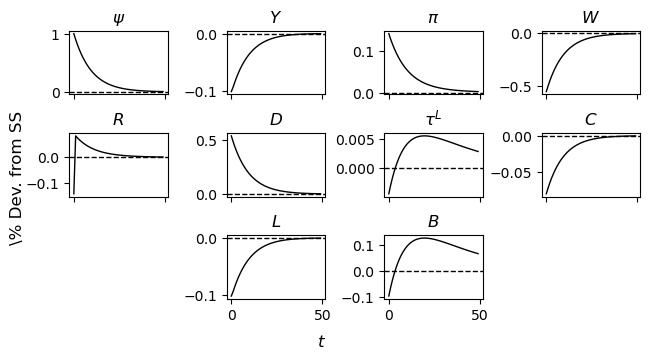

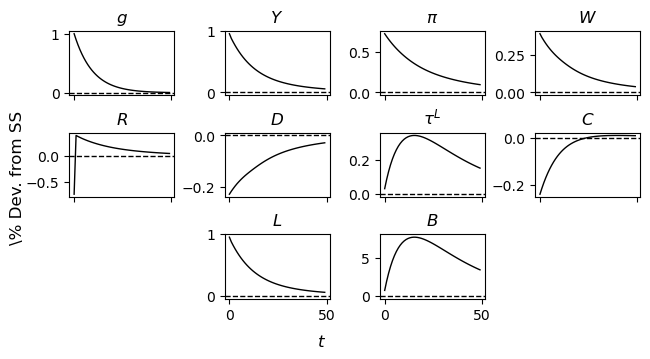

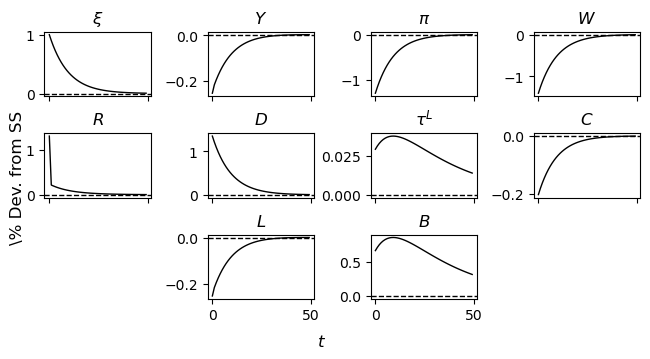

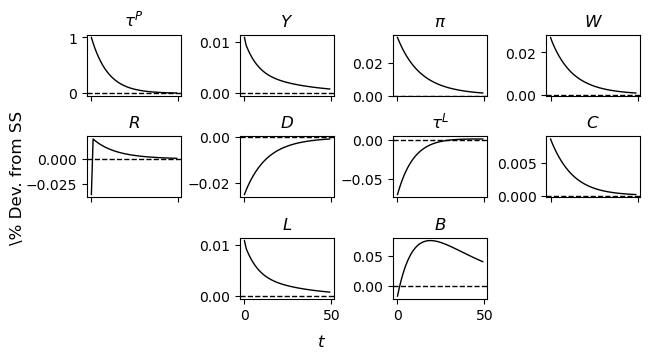

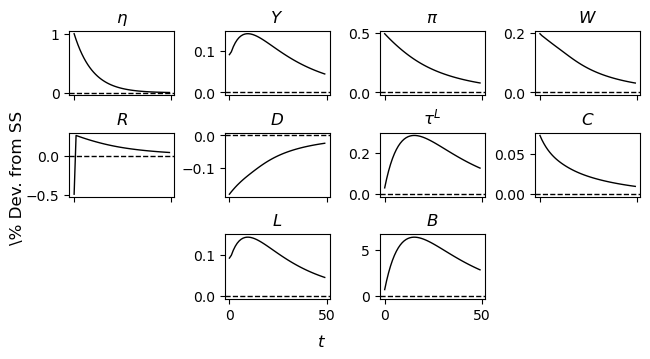

In [3]:
rhos = {s: 0.9 for s in hank.shocks}
sigmas = {s: 1 for s in hank.shocks}

tmax = 50
labels = {   # keys for labeling
        'A': '$A$', 'psi': r'$\psi$', 'g': '$g$', 'xi': r'$\xi$', 'tauP': r'$\tau^P$', 'eta': r'$\eta$',  # shocks
        'pi': r'$\pi$', 'W': '$W$', 'M': '$M$', 'D': '$D$', 'R': '$R$', 'I': '$I$', 'tauL': r'$\tau^L$',  # prices
        'curlC': '$C$', 'curlN': '$L$', 'curlB': '$B$',  # hh aggs
        'Y': '$Y$', 'N': '$N$', 'B': '$B$', 'G': '$G$',  # econ aggs
    }

for Z in hank.shocks:
    # solve irfs
    X_irfs, Z_irf = single_shock_irfs(G[Z], rhos[Z], T, sigma=sigmas[Z])

    # plot setup
    fig, axs = plt.subplots(3, 4, sharex=True)
    fig.set_figwidth(6.5)
    fig.set_figheight(3.5)
    fig.supxlabel('$t$')
    fig.supylabel(r'\% Dev. from SS')
    axs[2, 0].set_axis_off()
    axs[2, 3].set_axis_off()
    axs = np.delete(axs.flatten(), [8, 11])
    outcomes = ['Y', 'pi', 'W', 'R', 'D', 'tauL', 'curlC', 'curlN', 'curlB']

    # plot each irf
    axs[0].set_title(labels[Z])
    axs[0].plot(Z_irf[:tmax], '-k', linewidth=1)
    axs[0].axhline(0, c='k', ls='--', linewidth=1)
    for ax, X in zip(axs[1:], outcomes):
        ax.set_title(labels[X])
        ax.plot(X_irfs[X][:tmax], '-k', linewidth=1)
        ax.axhline(0, c='k', ls='--', linewidth=1)

    # final things
    fig.tight_layout(pad=0.5)
    # fig.savefig(f'paper/figures/{Z}_agg_irf.pgf')